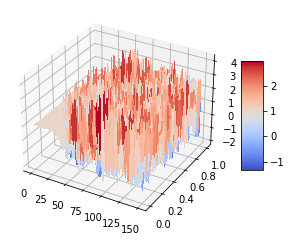

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

# KSequ.m - solution of Kuramoto-Sivashinsky equation
#
# u_t = -u*u_x - u_xx - u_xxxx, periodic boundary conditions on [0,32*pi]
# computation is based on v = fft(u), so linear term is diagonal
#
# Using this program:
# u is the initial condition
# h is the time step
# N is the number of points calculated along x
# a is the max value in the initial condition
# b is the min value in the initial condition
# x is used when using a periodic boundary condition, to set up in terms of
#   pi
#
# Initial condition and grid setup
N = 1024
x = np.transpose(np.conj(np.arange(1, N+1))) / N
a = -1
b = 1
u = np.cos(x/16)*(1+np.sin(x/16))
v = np.fft.fft(u)
# scalars for ETDRK4
h = 0.25
k = np.transpose(np.conj(np.concatenate((np.arange(0, N/2), np.array([0]), np.arange(-N/2+1, 0))))) / 16
L = k**2 - k**4
E = np.exp(h*L)
E_2 = np.exp(h*L/2)
M = 16
r = np.exp(1j*np.pi*(np.arange(1, M+1)-0.5) / M)
LR = h*np.transpose(np.repeat([L], M, axis=0)) + np.repeat([r], N, axis=0)
Q = h*np.real(np.mean((np.exp(LR/2)-1)/LR, axis=1))
f1 = h*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1))
f2 = h*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1))
f3 = h*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1))
# main loop
uu = np.array([u])
tt = 0
tmax = 150
nmax = round(tmax/h)
nplt = int((tmax/100)/h)
g = -0.5j*k
for n in range(1, nmax+1):
    t = n*h
    Nv = g*np.fft.fft(np.real(np.fft.ifft(v))**2)
    a = E_2*v + Q*Nv
    Na = g*np.fft.fft(np.real(np.fft.ifft(a))**2)
    b = E_2*v + Q*Na
    Nb = g*np.fft.fft(np.real(np.fft.ifft(b))**2)
    c = E_2*a + Q*(2*Nb-Nv)
    Nc = g*np.fft.fft(np.real(np.fft.ifft(c))**2)
    v = E*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
    if n%nplt == 0:
        u = np.real(np.fft.ifft(v))
        uu = np.append(uu, np.array([u]), axis=0)
        tt = np.hstack((tt, t))
# plot
fig = plt.figure()
ax = fig.gca(projection='3d')
tt, x = np.meshgrid(tt, x)
surf = ax.plot_surface(tt, x, uu.transpose(), cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [2]:
# install rkstiff

import numpy as np
from rkstiff import grids
from rkstiff import if34

# uniform grid spacing, real-valued u -> construct_x_kx_rfft
N = 512
a, b = -10, 10
x, kx = grids.construct_x_kx_rfft(N, a, b)

L = kx**2*(1-kx**2)
def NL(uFFT):
    u = np.fft.irfft(uFFT)
    ux = np.fft.irfft(1j*kx*uFFT)
    return -np.fft.rfft(u*ux)

u0 = -np.sin(np.pi*x/10)
u0FFT = np.fft.rfft(u0)
solver = if34.IF34(linop=L,NLfunc=NL)
ufFFT = solver.evolve(u0FFT, t0=0, tf=50, h_init=0.2) # store every 20th step in solver.u and solver.t

U = []
for uFFT in solver.u:
    U.append(np.fft.irfft(uFFT))
U = np.array(U)
t = np.array(solver.t)

X_sol, T_sol = np.meshgrid(x, t)
Exact = U.T